# Imports

In [ ]:
!pip install pycocotools

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import cv2
from PIL import Image
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import torch
from torch.utils.data import Dataset,DataLoader,Subset
import torchvision.transforms.functional as tf
import albumentations as A

# Configuration

In [5]:
img_dir="/kaggle/input/pothole-detection/images"
annot_dir="/kaggle/input/pothole-detection/annotations"

#label 0 is fixed for background
classes=["background","pothole"]

num_classes=2
device="cuda" if torch.cuda.is_available() else "cpu"
batch_size=4
epochs=40
learning_rate=3e-5

model_weights_file="model.pth"

threshold=0.2
iou_threshold=0.8

# Utility Function

In [6]:
def show_bbox(img,target,color=(0,255,0)):
    img=np.transpose(img.cpu().numpy(),(1,2,0))
    boxes=target["boxes"].cpu().numpy().astype("int")
    labels=target["labels"].cpu().numpy()
    img=img.copy()
    for i,box in enumerate(boxes):
        idx=int(labels[i])
        text=classes[idx]

        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,2)
        y=box[1]-10 if box[1]-10>10 else box[1]+10
        cv2.putText(img,text,(box[0],y),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)
        
    return img

In [7]:
def parse_xml(annot_path):
    tree=ET.parse(annot_path)
    root=tree.getroot()
    
    width=int(root.find("size").find("width").text)
    height=int(root.find("size").find("height").text)
    boxes=[]
    
    for obj in root.findall("object"):
        bbox=obj.find("bndbox")
        xmin=int(bbox.find("xmin").text)
        ymin=int(bbox.find("ymin").text)
        xmax=int(bbox.find("xmax").text)
        ymax=int(bbox.find("ymax").text)
        
        boxes.append([xmin,ymin,xmax,ymax])
        
    return boxes,height,width

In [8]:
def preprocess_bbox(prediction):
    
    """Non-max suppression is the final step of these object detection algorithms and is 
       used to select the most appropriate bounding box for the object.
       The NMS takes two things into account
        -The objectiveness score is given by the model
        -The overlap or IOU of the bounding boxes"""
    
    processed_bbox={}
    
    boxes=prediction["boxes"][prediction["scores"]>=threshold]
    scores=prediction["scores"][prediction["scores"]>=threshold]
    labels=prediction["labels"][prediction["scores"]>=threshold]
    nms=torchvision.ops.nms(boxes,scores,iou_threshold=iou_threshold)
            
    processed_bbox["boxes"]=boxes[nms]
    processed_bbox["scores"]=scores[nms]
    processed_bbox["labels"]=labels[nms]
    
    return processed_bbox

# Bounding Box Data Analysis

In [9]:
ignore_img=[]
for annot_name in os.listdir(annot_dir):
    img_name=annot_name[:-4]+".png"
    annot_path=os.path.join(annot_dir,annot_name)
    boxes,height,width=parse_xml(annot_path)
    
    for box in boxes:
        if box[0]<0 or box[0]>=box[2] or box[2]>width:
            print(box[0],box[2],width)
            print("x",annot_name)
            print("*"*50)
            ignore_img.append(img_name)
        elif box[1]<0 or box[1]>=box[3] or box[3]>height:
            print(box[1],box[3],height)
            print("y",file_name)
            print("*"*50)
            ignore_img.append(img_name)

273 273 400
x potholes58.xml
**************************************************
312 401 400
x potholes214.xml
**************************************************


In [10]:
ignore_img

['potholes58.png', 'potholes214.png']

# Data Augmentation

In [11]:
train_transform=A.Compose([A.HorizontalFlip(),
                           A.ShiftScaleRotate(rotate_limit=15,value=0,
                                              border_mode=cv2.BORDER_CONSTANT),

                           A.OneOf(
                                   [A.CLAHE(),
                                    A.RandomBrightnessContrast(),
                                    A.HueSaturationValue()],p=1),
                           A.GaussNoise(),
                           A.RandomResizedCrop(height=480,width=480)],
                          bbox_params=A.BboxParams(format="pascal_voc",min_visibility=0.15,
                                                   label_fields=["labels"]))
                           
val_transform=A.Compose([A.Resize(height=480,width=480)],
                        bbox_params=A.BboxParams(format="pascal_voc",min_visibility=0.15,
                                                 label_fields=["labels"]))

# Custom Dataset

In [12]:
class PotholeDetection(Dataset):
    def __init__(self,img_dir,annot_dir,transform=None):
        super().__init__()
        self.img_dir=img_dir
        self.annot_dir=annot_dir
        self.img_list=sorted([img for img in os.listdir(self.img_dir) 
                              if img not in ignore_img])
        self.transform=transform
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self,idx):
        img_name=self.img_list[idx]
        img_path=os.path.join(self.img_dir,img_name)
        img=cv2.imread(img_path)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        
        annot_name=img_name[:-4]+".xml"
        annot_path=os.path.join(self.annot_dir,annot_name)
        boxes,height,width=parse_xml(annot_path)
        labels=[1]*len(boxes)
        
        if self.transform is not None:
            transformed=self.transform(image=img,bboxes=boxes,labels=labels)
            img=transformed["image"]
            boxes=transformed["bboxes"]
            labels=transformed["labels"]
        
        if len(np.array(boxes).shape)!=2 or np.array(boxes).shape[-1]!=4:
            boxes=[[0.0,0.0,1.0,1.0]]
            labels=[0]
                
        img=img/255
        img=tf.to_tensor(img)
        img=img.to(dtype=torch.float32)
        target={}
        target["boxes"]=torch.tensor(boxes,dtype=torch.float32)
        target["labels"]=torch.tensor(labels,dtype=torch.int64)
        target["id"]=torch.tensor(idx)
            
        return img,target

In [13]:
train_ds=PotholeDetection(img_dir,annot_dir,train_transform)
val_ds=PotholeDetection(img_dir,annot_dir,val_transform)

In [14]:
from torch.utils.data import Subset

In [15]:
idxs=list(range(len(train_ds)))

np.random.shuffle(idxs)
train_idx=idxs[:int(0.85*len(train_ds))]
val_idx=idxs[int(0.85*len(train_ds)):]

train_ds=Subset(train_ds,train_idx)
val_ds=Subset(val_ds,val_idx)

In [16]:
len(val_ds)

100

# Data Visualization

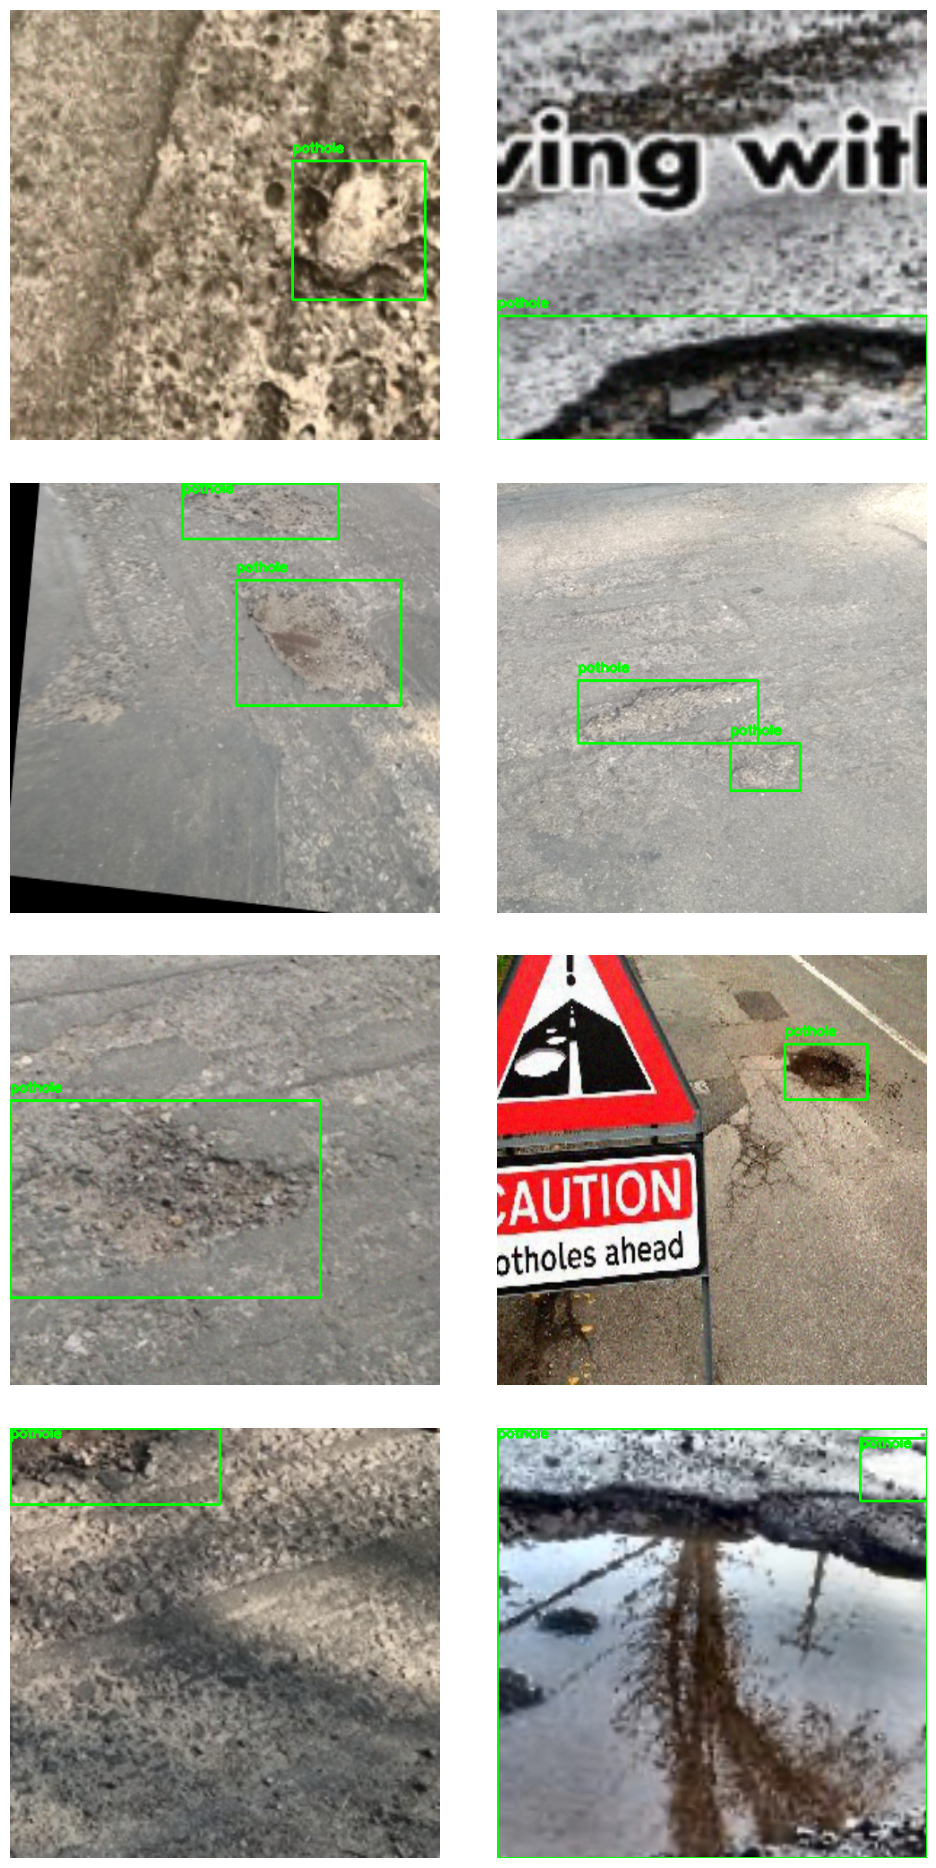

In [17]:
fig,axes=plt.subplots(4,2,figsize=(12,24))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()

idxs=np.random.choice(range(len(train_ds)),8)
for i,idx in enumerate(idxs):
    img,target=train_ds[idx]
    output_img=show_bbox(img,target)
    ax[i].imshow(output_img)
    ax[i].axis("off")

# DataLoader

In [18]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [19]:
train_dl=DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=os.cpu_count(),
                    collate_fn=collate_fn,
                    pin_memory=True if device=="cuda" else False)
val_dl=DataLoader(val_ds,batch_size=batch_size,shuffle=False,num_workers=os.cpu_count(),
                  collate_fn=collate_fn,
                  pin_memory=True if device=="cuda" else False)

# Model

In [20]:
from torchvision.models.detection.ssd import SSDHead,det_utils
from torchvision.models.detection import ssd300_vgg16,SSD300_VGG16_Weights

In [ ]:
import torch.optim as optim
import torchvision

In [ ]:
model=ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)

in_channels=det_utils.retrieve_out_channels(model.backbone,(480,480))
num_anchors=model.anchor_generator.num_anchors_per_location()
model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                   num_classes=num_classes)

model.to(device)

In [22]:
for params in model.backbone.features.parameters():
    params.requires_grad=False
    
parameters=[params for params in model.parameters() if params.requires_grad]

optimizer=optim.Adam(parameters,lr=learning_rate)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, 
                                                  patience=7, threshold=0.0001)

# Training

In [23]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]

In [24]:
import copy

In [25]:
loss_history={"training_loss":[],
              "validation_loss":[]}

train_len=len(train_dl.dataset)
val_len=len(val_dl.dataset)

best_validation_loss=np.inf
best_weights=copy.deepcopy(model.state_dict())

for epoch in range(epochs):
    
    training_loss=0.0
    validation_loss=0.0
    
    current_lr=get_lr(optimizer)
    
    #During training, the model expects both the input tensors, as well as a targets 
    model.train()
    for imgs,targets in train_dl:
        imgs=[img.to(device) for img in imgs]
        targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
        
        loss_dict=model(imgs,targets)
        losses=sum(loss for loss in loss_dict.values())
        training_loss+=losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    with torch.no_grad():
        for imgs,targets in val_dl:
            imgs=[img.to(device) for img in imgs]
            targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
            
            loss_dict=model(imgs,targets)
            losses=sum(loss for loss in loss_dict.values())
            validation_loss+=losses.item()
        
            
    lr_scheduler.step(validation_loss)
    if current_lr!=get_lr(optimizer):
        print("Loading best Model weights")
        model.load_state_dict(best_weights)
    
    if validation_loss<best_validation_loss:
        best_validation_loss=validation_loss
        best_weights=copy.deepcopy(model.state_dict())
        print("Updating Best Model weights")
        
    
    loss_history["training_loss"].append(training_loss/train_len)
    loss_history["validation_loss"].append(validation_loss/val_len)
            
    print(f"\n{epoch+1}/{epochs}")
    print(f"Training Loss: {training_loss/train_len}")
    print(f"Validation_loss: {validation_loss/val_len}")
    print("\n"+"*"*50)

torch.save(best_weights,model_weights_file)

Updating Best Model weights

1/60
Training Loss: 1.5700876556111907
Validation_loss: 1.3269582319259643

**************************************************
Updating Best Model weights

2/60
Training Loss: 1.3378554212051852
Validation_loss: 1.2273743486404418

**************************************************
Updating Best Model weights

3/60
Training Loss: 1.2777843839533587
Validation_loss: 1.144141263961792

**************************************************
Updating Best Model weights

4/60
Training Loss: 1.1790324244151953
Validation_loss: 1.0673507308959962

**************************************************
Updating Best Model weights

5/60
Training Loss: 1.1376981146593923
Validation_loss: 1.0228668808937074

**************************************************
Updating Best Model weights

6/60
Training Loss: 1.093066876989063
Validation_loss: 0.9683218789100647

**************************************************
Updating Best Model weights

7/60
Training Loss: 1.051070757064683

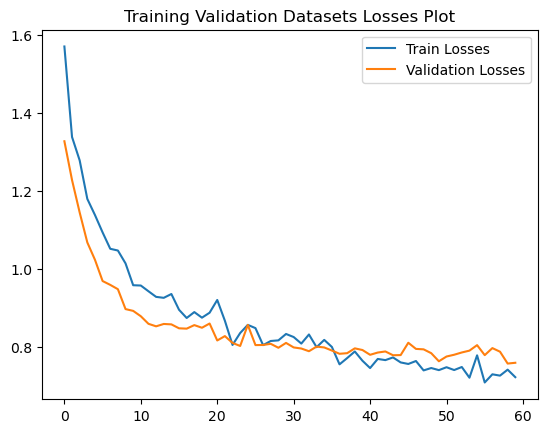

In [27]:
sns.lineplot(x=range(epochs),y=loss_history["training_loss"],label="Train Losses");
sns.lineplot(x=range(epochs),y=loss_history["validation_loss"],label="Validation Losses");
plt.title("Training Validation Datasets Losses Plot");

# Evaluation

In [28]:
import pycocotools
import torchmetrics
from torchmetrics.detection import MeanAveragePrecision

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [43]:
metric=MeanAveragePrecision(box_format='xyxy',class_metrics=True)
metric.to(device)

model.eval()
with torch.no_grad():
    for imgs,targets in val_dl:
        imgs=[img.to(device) for img in imgs]
        targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
        predictions=model(imgs)
        
        results=[]
        for prediction in predictions:
            results.append(preprocess_bbox(prediction))
        
        metric.update(results,targets)
        
results=metric.compute()

In [44]:
mean_ap=results["map"].item()
mean_ap_50=results["map_50"].item()
mean_ap_75=results["map_75"].item()

print(f"Mean Average Precision[0.5:0.95:0.05] : {mean_ap:.4f}")
print(f"Mean Average Precision @ 0.5          : {mean_ap_50:.4f}")
print(f"Mean Average Precision @ 0.75         : {mean_ap_75:.4f}")

Mean Average Precision[0.5:0.95:0.05] : 0.3738
Mean Average Precision @ 0.5          : 0.5410
Mean Average Precision @ 0.75         : 0.4194


# Inference

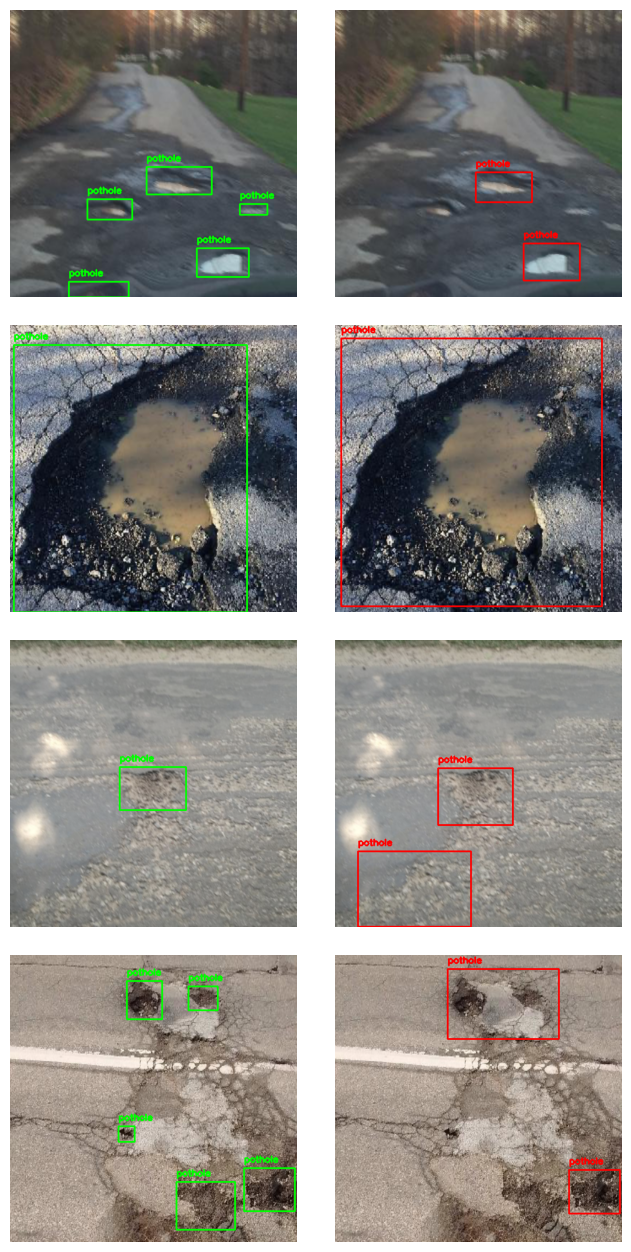

In [45]:
"""During inference, the model requires only the input tensors, and returns the 
   post-processed predictions as a List[Dict[Tensor]], one for each input image. The fields
   of the Dict are as follows:
   - boxes (FloatTensor[N, 4]): the predicted boxes in [x0, y0, x1, y1] format
   - labels (Int64Tensor[N]): the predicted labels for each image
   - scores (Tensor[N]): the scores or each prediction"""

fig,axes=plt.subplots(4,2,figsize=(8,16))
plt.subplots_adjust(wspace=0.1,hspace=0.1)

imgs,targets=next(iter(val_dl))
model.eval()
with torch.no_grad():
    output=model([img.to(device) for img in imgs])

for i,idx in enumerate(range(len(imgs))):
    img=imgs[idx]
    prediction=output[idx]
    
    #real bounding boxes
    output_img=show_bbox(img,targets[idx],color=(0,255,0));
    axes[i,0].imshow(output_img);
    axes[i,0].axis("off");
    
    #predicted bounding box
    predict=preprocess_bbox(prediction)
    output_img=show_bbox(img,predict,color=(255,0,0));
    axes[i,1].imshow(output_img);
    axes[i,1].axis("off");
    
plt.savefig("4.png")

# Video Inference

In [54]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

In [65]:
! pip install -U ffmpeg

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6084 sha256=fae03375ff457781c169b1610544431091f4eed3ef78ce3ea2e37ffd38a2a83b
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


In [ ]:
"""video_path="/kaggle/input/potholes-detection-inference-on-videos/pothole.mp4"
cap=cv2.VideoCapture(video_path)
if (cap.isOpened() == False):
    print('Error while trying to read video. Please check path again')
    
# get the frame width and height
video_out_path="/kaggle/working/output_video.mp4"

# define codec and create VideoWriter object 
out=cv2.VideoWriter(video_out_path, 
                    cv2.VideoWriter_fourcc(*'XVID'), 30, 
                    (480,480))

model=model.eval()

# read until end of video
while(cap.isOpened()):
    # capture each frame of the video
    ret, frame=cap.read()
    if ret==True:
        with torch.no_grad():
            # get predictions for the current frame
            frame=cv2.resize(480,480)
            frame=frame/255
            frame=(frame-mean)/std
            frame=np.transpose(frame,(2,0,1))
            frame=torch.as_tensor(frame,dtype=torch.float32)
            frame=frame.to(device)
            output=model([frame])
            predict=preprocess_bbox(output[0])
            output_img=show_bbox(frame,predict);
            plt.imshow(output_img)
            output_img=(output_img*255).astype(np.uint8)
            out.write(output_img)
    else:
        break
        
# release VideoCapture()
out.release()
cap.release()"""

In [ ]:
"""from IPython.display import HTML
from base64 import b64encode

def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=1000 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

play('/kaggle/working/output_video.mp4')"""